# Binary Classification Model for Santander Customer Satisfaction Using Scikit-Learn Take 1
### David Lowe
### June 26, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Santander Customer Satisfaction dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Santander Bank sponsored a Kaggle competition to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late. In this competition, Santander has provided hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience. The exercise evaluates the submissions on the area under the ROC curve (AUC) between the predicted probability and the observed target.

In this Take1 iteration, we will construct and tune several machine learning models using the Scikit-learn library. Furthermore, we will apply the best-performing machine learning model to Kaggle's test dataset and submit a list of predictions for evaluation.

ANALYSIS: In this Take1 iteration, the baseline performance of the machine learning algorithms achieved an average AUC of 68.10%. Two algorithms (Random Forest and Gradient Boosting) achieved the top AUC metrics after the first round of modeling. After a series of tuning trials, the Gradient Boosting model turned in a better overall result than Random Forest with a higher AUC. Gradient Boosting achieved an AUC metric of 83.54%, and the same Gradient Boosting model processed the test dataset with an AUC of 83.50% which was consistent with the training result. However, when we applied the Gradient Boosting model to the test dataset from Kaggle, we obtained a ROC-AUC score of only 73.02%.

CONCLUSION: For this iteration, the Gradient Boosting model achieved the best overall result using the training and test datasets. For this dataset, we should consider Gradient Boosting and other machine learning algorithms for further modeling and testing.

Dataset Used: Santander Customer Satisfaction Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/santander-customer-satisfaction/overview

One potential source of performance benchmark: https://www.kaggle.com/c/santander-customer-satisfaction/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import smtplib
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'roc_auc'

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = "arn:aws:sns:us-east-1:072417399597:PythonMLScriptNotification"
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-santander-customer-satisfaction/train.csv'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
Xy_original.head(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,13,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,14,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,18,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,20,2,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,23,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000,0


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 371 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ID                             int64  
 1   var3                           int64  
 2   var15                          int64  
 3   imp_ent_var16_ult1             float64
 4   imp_op_var39_comer_ult1        float64
 5   imp_op_var39_comer_ult3        float64
 6   imp_op_var40_comer_ult1        float64
 7   imp_op_var40_comer_ult3        float64
 8   imp_op_var40_efect_ult1        float64
 9   imp_op_var40_efect_ult3        float64
 10  imp_op_var40_ult1              float64
 11  imp_op_var41_comer_ult1        float64
 12  imp_op_var41_comer_ult3        float64
 13  imp_op_var41_efect_ult1        float64
 14  imp_op_var41_efect_ult3        float64
 15  imp_op_var41_ult1              float64
 16  imp_op_var39_efect_ult1        float64
 17  imp_op_var39_efect_ult3        float64
 18  imp_o

In [12]:
Xy_original.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [13]:
Xy_original.isnull().sum()

ID                               0
var3                             0
var15                            0
imp_ent_var16_ult1               0
imp_op_var39_comer_ult1          0
imp_op_var39_comer_ult3          0
imp_op_var40_comer_ult1          0
imp_op_var40_comer_ult3          0
imp_op_var40_efect_ult1          0
imp_op_var40_efect_ult3          0
imp_op_var40_ult1                0
imp_op_var41_comer_ult1          0
imp_op_var41_comer_ult3          0
imp_op_var41_efect_ult1          0
imp_op_var41_efect_ult3          0
imp_op_var41_ult1                0
imp_op_var39_efect_ult1          0
imp_op_var39_efect_ult3          0
imp_op_var39_ult1                0
imp_sal_var16_ult1               0
ind_var1_0                       0
ind_var1                         0
ind_var2_0                       0
ind_var2                         0
ind_var5_0                       0
ind_var5                         0
ind_var6_0                       0
ind_var6                         0
ind_var8_0          

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'TARGET': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['ID','var3'], inplace=True)

# Correct mis-coding for some features
Xy_original.loc[(Xy_original.var38 > 350000.00), 'var38'] = 350000.00

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,targetVar
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350000.000000,0


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 369 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   var15                          int64  
 1   imp_ent_var16_ult1             float64
 2   imp_op_var39_comer_ult1        float64
 3   imp_op_var39_comer_ult3        float64
 4   imp_op_var40_comer_ult1        float64
 5   imp_op_var40_comer_ult3        float64
 6   imp_op_var40_efect_ult1        float64
 7   imp_op_var40_efect_ult3        float64
 8   imp_op_var40_ult1              float64
 9   imp_op_var41_comer_ult1        float64
 10  imp_op_var41_comer_ult3        float64
 11  imp_op_var41_efect_ult1        float64
 12  imp_op_var41_efect_ult3        float64
 13  imp_op_var41_ult1              float64
 14  imp_op_var39_efect_ult1        float64
 15  imp_op_var39_efect_ult3        float64
 16  imp_op_var39_ult1              float64
 17  imp_sal_var16_ult1             float64
 18  ind_v

In [17]:
Xy_original.describe()

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,targetVar
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,110639.606455,0.039569
std,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,63019.263719,0.194945
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000,0.000000
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500,0.000000
50%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106409.160000,0.000000
75%,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,118756.252500,0.000000
max,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,12888.030000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,350000.000000,1.000000


In [18]:
Xy_original.isnull().sum()

var15                            0
imp_ent_var16_ult1               0
imp_op_var39_comer_ult1          0
imp_op_var39_comer_ult3          0
imp_op_var40_comer_ult1          0
imp_op_var40_comer_ult3          0
imp_op_var40_efect_ult1          0
imp_op_var40_efect_ult3          0
imp_op_var40_ult1                0
imp_op_var41_comer_ult1          0
imp_op_var41_comer_ult3          0
imp_op_var41_efect_ult1          0
imp_op_var41_efect_ult3          0
imp_op_var41_ult1                0
imp_op_var39_efect_ult1          0
imp_op_var39_efect_ult3          0
imp_op_var39_ult1                0
imp_sal_var16_ult1               0
ind_var1_0                       0
ind_var1                         0
ind_var2_0                       0
ind_var2                         0
ind_var5_0                       0
ind_var5                         0
ind_var6_0                       0
ind_var6                         0
ind_var8_0                       0
ind_var8                         0
ind_var12_0         

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (76020, 369) X_original.shape: (76020, 368) y_original.shape: (76020,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
5,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000
6,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000
7,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000
8,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000
9,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350000.000000


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 368 entries, var15 to var38
dtypes: float64(111), int64(257)
memory usage: 213.4 MB


#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,...,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,110639.606455
std,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,...,31.879418,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,63019.263719
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500
50%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106409.160000
75%,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,118756.252500
max,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,12888.030000,...,7331.340000,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,350000.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [28]:
Xy_original.groupby('targetVar').size()

targetVar
0    73012
1     3008
dtype: int64

### 2.b) Data Visualization

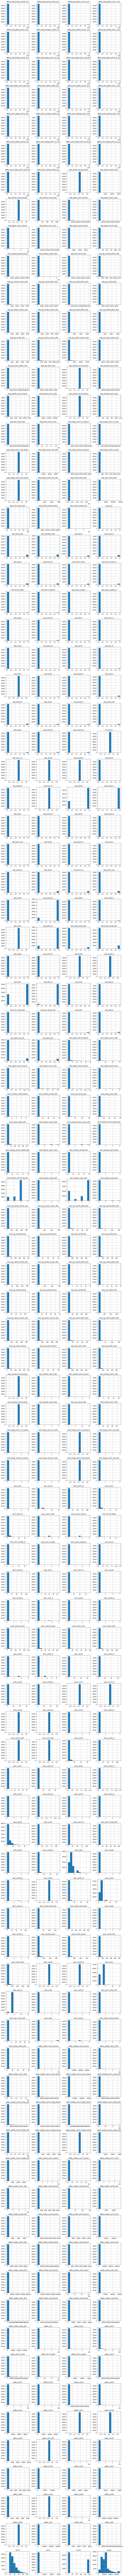

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

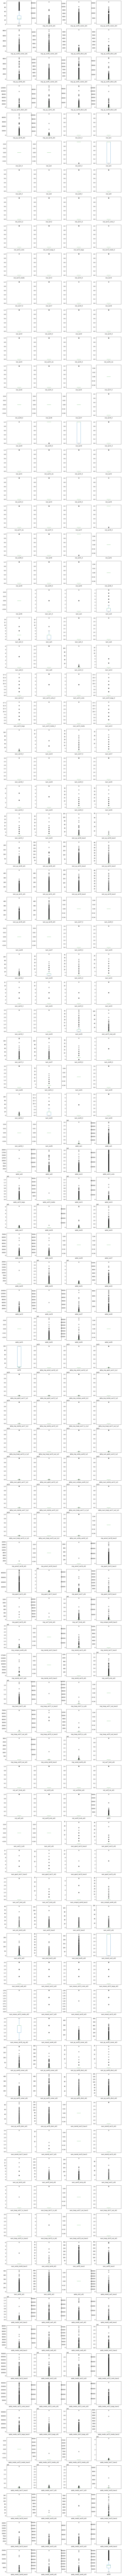

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [31]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [32]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [35]:
# Split the data further into training and test datasets
if splitDataset:
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (57015, 368) y_train_df.shape: (57015,)
X_test_df.shape: (19005, 368) y_test_df.shape: (19005,)


### 3.b) Feature Scaling and Data Pre-Processing

In [36]:
# Apply feature scaling techniques
columns_to_scale = ['var15','var38']
scaler = preprocessing.StandardScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])

X_original[columns_to_scale].head(10)

,var15,var38
0,-0.788249,-1.133541
1,0.060753,-0.973702
2,-0.788249,-0.687189
3,0.292298,-0.739963
4,0.446662,0.105863
5,-0.788249,-0.359636
6,-0.479521,-0.248861
7,-0.556703,2.237415
8,0.909754,-0.137698
9,-0.633885,3.798235


In [37]:
X_original.var38.describe()

count    7.602000e+04
mean    -1.928242e-16
std      1.000007e+00
min     -1.673719e+00
25%     -6.786699e-01
50%     -6.712986e-02
75%      1.287971e-01
max      3.798235e+00
Name: var38, dtype: float64

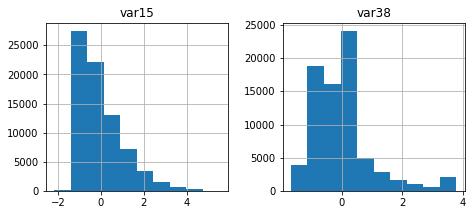

In [38]:
# Histograms for each attribute
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

### 3.c) Training Data Balancing

In [39]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [40]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (57015, 368) y_train.shape: (57015,)
X_test.shape: (19005, 368) y_test.shape: (19005,)


In [42]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [43]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [44]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')))

In [45]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGR: 0.598979 (0.007974)
LogisticRegression(random_state=888)
Model training time: 0:00:22.289658 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.575920 (0.011545)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:31.230606 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 70.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.584912 (0.009047)
KNeighborsClassifier(n_jobs=1)
Model training time: 1:10:00.521964 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.703362 (0.010891)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:03:02.185182 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.756276 (0.005442)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:02:36.127803 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


EXT: 0.712731 (0.011930)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:03:01.813542 

GBM: 0.835456 (0.003500)
GradientBoostingClassifier(random_state=888)
Model training time: 0:11:06.842619 

Average metrics (roc_auc) from all models: 0.6810908056458277
Total training time for all models: 1:30:41.153840


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.1min finished


### 4.b) Spot-checking baseline algorithms

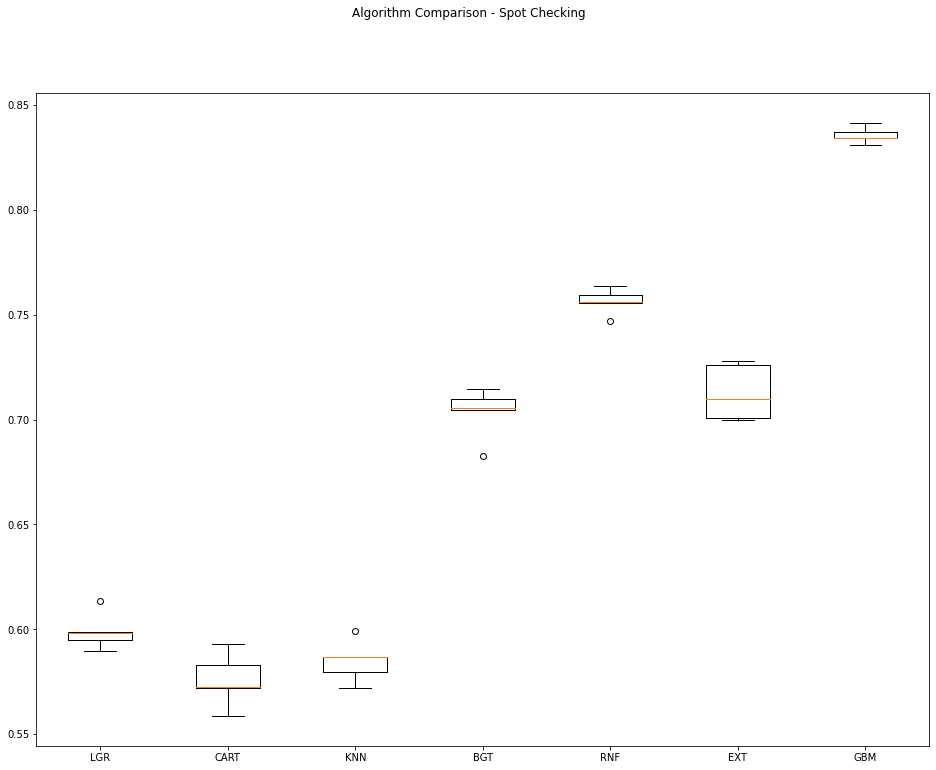

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [47]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [48]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [49]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [50]:
# Tuning algorithm #1 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500, 700, 900]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 68.2min finished


Best: 0.765709 using {'n_estimators': 900}
0.756276 (0.005442) with: {'n_estimators': 100}
0.763841 (0.006991) with: {'n_estimators': 300}
0.765379 (0.006568) with: {'n_estimators': 500}
0.765593 (0.006436) with: {'n_estimators': 700}
0.765709 (0.006365) with: {'n_estimators': 900}
Model training time: 1:14:06.758648


In [51]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 900


In [52]:
# Tuning algorithm #2 - Gradient Boosting
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = GradientBoostingClassifier(random_state=seedNum)
tune_model_names.append('GBM')
paramGrid2 = dict(n_estimators=np.array([50, 75, 100, 125, 150]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 56.1min finished


Best: 0.835456 using {'n_estimators': 100}
0.832786 (0.002444) with: {'n_estimators': 50}
0.834710 (0.003328) with: {'n_estimators': 75}
0.835456 (0.003500) with: {'n_estimators': 100}
0.835325 (0.004141) with: {'n_estimators': 125}
0.835367 (0.004277) with: {'n_estimators': 150}
Model training time: 0:58:29.872203


In [53]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 5.b) Compare Algorithms After Tuning

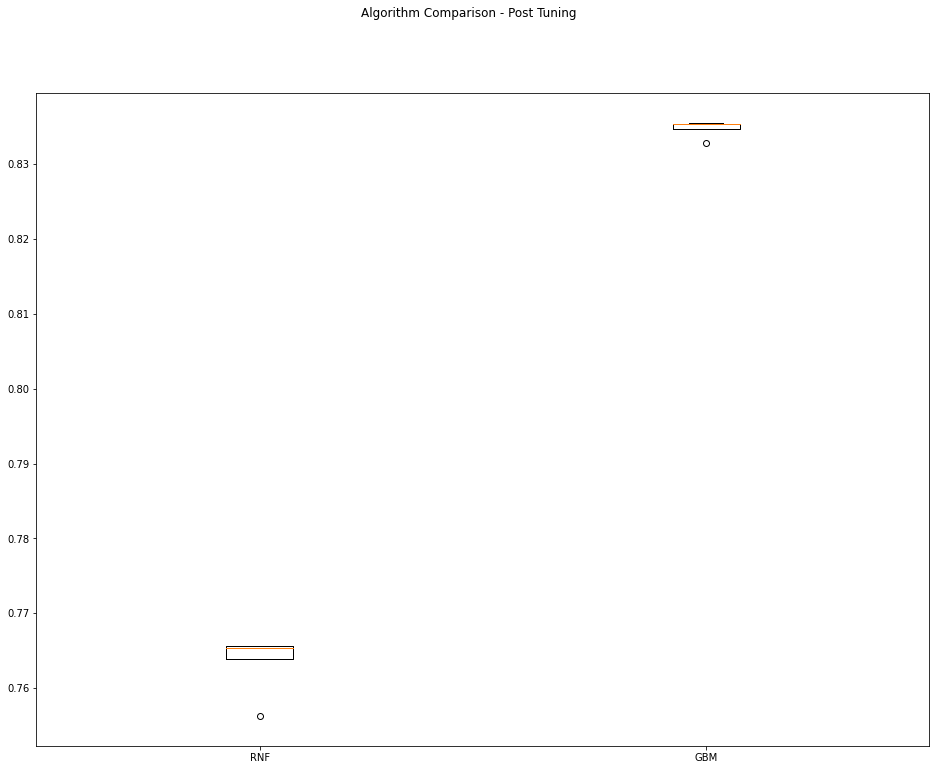

In [54]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [55]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [56]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [57]:
test_model = GradientBoostingClassifier(n_estimators=best_paramValue2, random_state=seedNum)
test_model.fit(X_train, y_train)
predictions = test_model.predict(X_test)
probabilities = test_model.predict_proba(X_test)[:,1]
print('Accuracy Score:', accuracy_score(y_test, predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, probabilities))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(test_model)

Accuracy Score: 0.9596948171533807
ROC/AUC Score: 0.8350001631908949
[[18233    20]
 [  746     6]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18253
           1       0.23      0.01      0.02       752

    accuracy                           0.96     19005
   macro avg       0.60      0.50      0.50     19005
weighted avg       0.93      0.96      0.94     19005

GradientBoostingClassifier(random_state=888)


### 6.b) Create a standalone model using all available data

In [58]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
final_model = test_model.fit(X_complete, y_complete)
print(final_model)

X_complete.shape: (76020, 368) y_complete.shape: (76020,)
GradientBoostingClassifier(random_state=888)


### 6.c) Create Submission Files for Kaggle Evaluation

In [59]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-santander-customer-satisfaction/test.csv'
X_kaggle_data = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
X_kaggle_data.head(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,73649.73
5,11,2,43,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,53250.87
6,12,2,39,495.0,2334.42,4815.42,0.0,0.0,0.0,0.0,...,0.0,7077.51,0.0,7599.0,7338.27,0.0,0.0,0.0,0.0,58316.64
7,15,2,29,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46898.49
8,16,2,53,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,110356.98
9,17,2,37,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,41366.49


In [60]:
# Set up the dataframe to capture predictions for Kaggle submission
y_submission_kaggle = pd.DataFrame(columns=['ID', 'TARGET'])
y_submission_kaggle['ID'] = X_kaggle_data['ID']
y_submission_kaggle.head()

,ID,TARGET
0,2,NaN
1,5,NaN
2,6,NaN
3,7,NaN
4,9,NaN


In [61]:
# Check to see whether the test dataset contains any NaN
null_counts = X_kaggle_data.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [62]:
print('Total number of NaN in the dataframe: ', X_kaggle_data.isnull().sum().sum())

Total number of NaN in the dataframe:  0


In [63]:
# Apply the same data pre-processing steps to the test data
X_kaggle_data.drop(columns=['ID','var3'], inplace=True)

# Correct mis-coding for some features
X_kaggle_data.loc[(X_kaggle_data.var38 > 350000.00), 'var38'] = 350000.00

X_kaggle_data.head(10)

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,40532.10
1,35,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,45486.72
2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46993.95
3,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,187898.61
4,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,73649.73
5,43,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,53250.87
6,39,495.0,2334.42,4815.42,0.0,0.0,0.0,0.0,0.0,2334.42,...,0.0,7077.51,0.0,7599.0,7338.27,0.0,0.0,0.0,0.0,58316.64
7,29,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46898.49
8,53,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,110356.98
9,37,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,41366.49


In [64]:
# Check to see whether the test dataset contains any NaN
null_counts = X_kaggle_data.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [65]:
print('Total number of NaN in the dataframe: ', X_kaggle_data.isnull().sum().sum())

Total number of NaN in the dataframe:  0


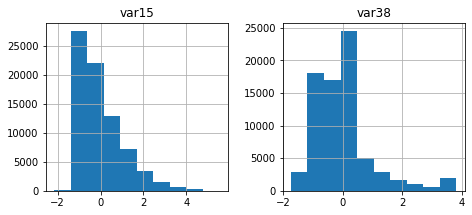

In [66]:
# Perform the same pre-processing of the numeric attributes
X_kaggle_data[columns_to_scale] = scaler.fit_transform(X_kaggle_data[columns_to_scale])
X_kaggle_data[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [67]:
# Test the Kaggle dataframe to ensure it has the indentical set of columns with X_original
columns_original = X_original.columns.tolist()
columns_kaggle = X_kaggle_data.columns.tolist()
print('Attributes in the training data frame but not in the Kaggle test data frame:')
set(columns_original).difference(set(columns_kaggle))

Attributes in the training data frame but not in the Kaggle test data frame:


set()

In [68]:
print('Attributes in the Kaggle test data frame but not in the training data frame:')
set(columns_kaggle).difference(set(columns_original))

Attributes in the Kaggle test data frame but not in the training data frame:


set()

In [69]:
# Convert the dataframe to numpy array before the final prediction step
X_test_kaggle = X_kaggle_data.to_numpy()
print("X_test_kaggle.shape: {}".format(X_test_kaggle.shape))

X_test_kaggle.shape: (75818, 368)


In [70]:
probabilities_kaggle = final_model.predict_proba(X_test_kaggle)[:,1]
y_submission_kaggle['TARGET'] = probabilities_kaggle
print("y_submission_kaggle.shape: {}".format(y_submission_kaggle.shape))

y_submission_kaggle.shape: (75818, 2)


In [71]:
submission_file = y_submission_kaggle.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20200618-1952.csv


In [72]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [73]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:54:36.685650
